# Data Pipeline

This notebook describes the pipeline for milestone 3 for our project. It should give an overview of how we intend to load, clean, parse and exploit our data for our story telling.

## Imports

In [3]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and cleaning the data

Given the data size, pandas dataframe will be used.

## Handling data

In [4]:
CHARACTER_DATA_PATH = './data/character.metadata.tsv'
MOVIE_DATA_PATH = './data/movie.metadata.tsv'
SUMMARIES_DATA_PATH = './data/plot_summaries.txt'
NAME_DATA_PATH = './data/name.clusters.txt'
TYPE_DATA_PATH = './data/tvtropes.clusters.txt'

## Characters data

In [6]:
CHARACTER_HEADER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name',
                    'Actor_date_of_birth','Actor_gender','Actor_height','Actor_ethnicity','Actor_name',
                    'Actor_age_at_movie_release','Freebase_character/actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
character = pd.read_table(CHARACTER_DATA_PATH,header=None,names=CHARACTER_HEADER)

In [7]:
character.describe()

,Wikipedia_movie_ID,Actor_height,Actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


First, we want to clean the dataset :
- negative ages should be removed
- actor's height > 2.5 as well, as they become irrelevant compared to the true height of actors
- dates converted to correct format

In [8]:
character['Actor_age_at_movie_release'] = character['Actor_age_at_movie_release'].apply(lambda x: np.nan if x < 0 else x)
character['Actor_height'] = character['Actor_height'].apply(lambda x: np.nan if x > 2.5 else x)
character['Movie_release_date'] = pd.to_datetime(character['Movie_release_date'],format='mixed',utc=True,errors='coerce')
character['Actor_date_of_birth'] = pd.to_datetime(character['Actor_date_of_birth'],format='mixed',utc=True,errors='coerce')
character.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
92600,277148,/m/01pgnr,1997-06-20 00:00:00+00:00,Michael O'Neal,1963-10-31 00:00:00+00:00,M,1.770,/m/033tf_,Dermot Mulroney,33.0,/m/0k0_14,/m/02nwjr_,/m/074tb5
313081,485540,/m/02g5q1,1997-11-21 00:00:00+00:00,Kitana,1967-03-27 00:00:00+00:00,F,1.770,/m/09v5bdn,Talisa Soto,30.0,/m/0k0tzw,/m/03vhwd,/m/04p_tk
407814,2260985,/m/02y_5dv,NaT,NaN,1929-07-05 00:00:00+00:00,F,1.570,NaN,Katherine Helmond,NaN,/m/04dcgp3,NaN,/m/027txy
387560,3866944,/m/0b422t,1990-01-01 00:00:00+00:00,NaN,1933-07-05 00:00:00+00:00,M,1.842,NaN,Terence Cooper,56.0,/m/0k57mk,NaN,/m/02gx6m
22674,21380202,/m/05f8qh9,1972-05-19 00:00:00+00:00,Hamp Gurney,1915-05-15 00:00:00+00:00,M,NaN,NaN,Jack Watson,57.0,/m/0n1yygw,/m/0n1zp2z,/m/0fcc2q


## TODO
Should modify the ethnicityto give corresponding freebase ID. https://pypi.org/project/freebase/

### Movies data

In [9]:
MOVIE_HEADER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date',
                'Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']

movie = pd.read_table(MOVIE_DATA_PATH,header=None,names=MOVIE_HEADER)


In [10]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


The next cell will transform the dictionaries we might find in the cells of our data frames into comma-separated strings.

In [11]:
def format_dict(x):
    n = len(x)
    if n==0:
        return np.nan
    else:
        return ','.join(str(s) for s in list(x.values()))
    

try :

    movie['Movie_genres'] = movie['Movie_genres'].apply(json.loads).apply(format_dict)
    movie['Movie_countries'] = movie['Movie_countries'].apply(json.loads).apply(format_dict)
    movie['Movie_languages'] = movie['Movie_languages'].apply(json.loads).apply(format_dict)
except json.decoder.JSONDecodeError:
    print('Data has already been parsed and modified.')



There is a bit of cleaning to perform :
- we will focus on movies whose runtime is < 15000, because that is the longest movie we found to have its true length.
- dates to correct format

In [12]:
movie['Movie_runtime'] = movie['Movie_runtime'].apply(lambda x: np.nan if 1 > x or x > 15000 else x)
movie['Movie_release_date'] = pd.to_datetime(movie['Movie_release_date'],format='mixed',utc=True,errors='coerce')
movie.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
19953,25912151,/m/0b6hfy5,Preacher's Sons,2008-01-01 00:00:00+00:00,NaN,90.0,English Language,United States of America,Documentary
8266,25754499,/m/09v72q1,Panoptikum 59,1959-06-01 00:00:00+00:00,NaN,94.0,NaN,Austria,Drama
61566,8635248,/m/027by1x,Secrets of the Heart,1997-01-01 00:00:00+00:00,NaN,102.0,Spanish Language,"France,Spain,Portugal","Drama,World cinema"
20433,34220997,/m/0crrlqh,Kohram,1999-08-13 00:00:00+00:00,NaN,90.0,Hindi Language,India,"Thriller,Action,Drama,World cinema"
13656,1888433,/m/063yb4,The Americanization of Emily,1964-10-27 00:00:00+00:00,NaN,115.0,English Language,United States of America,"Romantic comedy,Black-and-white,Drama,Comedy,W..."


In [10]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,61233.000000
mean,1.740784e+07,4.799363e+07,94.298795
std,1.098791e+07,1.121753e+08,91.294848
min,3.300000e+02,1.000000e+04,1.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,14400.000000


## Summaries data

In [11]:
summaries = pd.read_table(SUMMARIES_DATA_PATH,header=None,names=['Wikipedia_movie_ID','Summary'])
summaries.head()

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Character names data

In [12]:
name = pd.read_table(NAME_DATA_PATH,header=None,names=['Character_name','Freebase_character/actor_map_ID'])
name.head()

,Character_name,Freebase_character/actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


## Character types data

In [13]:
character_type = pd.read_table(TYPE_DATA_PATH,header=None,names=['Character_type','Instance'])
character_type = pd.concat([character_type, character_type['Instance'].apply(json.loads).apply(pd.Series)], axis=1)
character_type.drop(columns='Instance',inplace=True)
character_type.rename(columns={'char': 'Character_name','movie': 'Movie_name','id': 'Freebase_character/actor_map_ID',
                               'actor': 'Actor_name'},inplace=True)
character_type.head()

,Character_type,Character_name,Movie_name,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


# Visualizing data

Here a few visualiztions are provided to get a glimpse of the data.

## Characters dataset

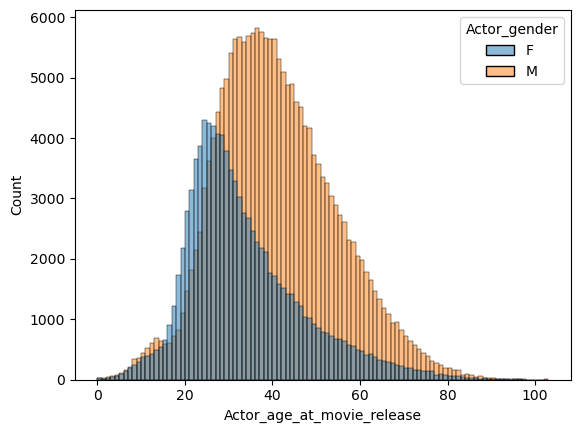

In [14]:
sns.histplot(data=character,x='Actor_age_at_movie_release',hue='Actor_gender',binwidth=1);

(1.4, 2.1)

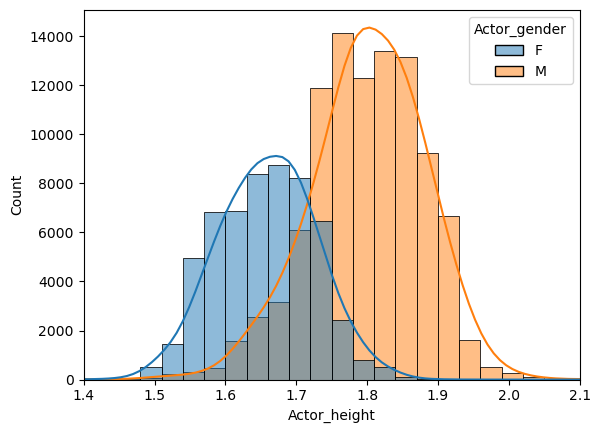

In [15]:
sns.histplot(data=character,x='Actor_height',hue='Actor_gender',binwidth=0.03,kde=True,kde_kws={'bw_adjust':3})
plt.xlim([1.4,2.1])

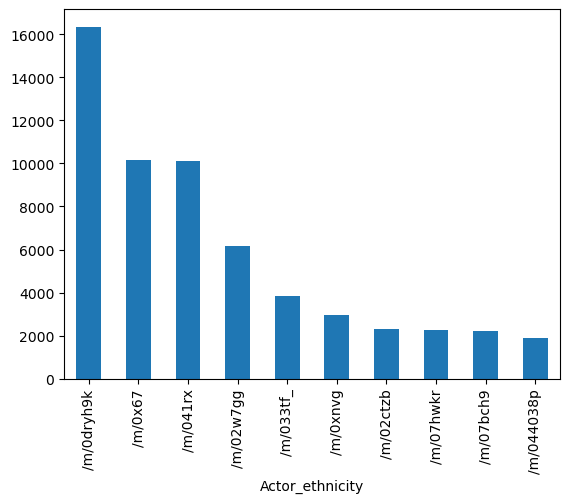

In [16]:
character['Actor_ethnicity'].value_counts().head(10).plot(kind='bar');

## Movies dataset

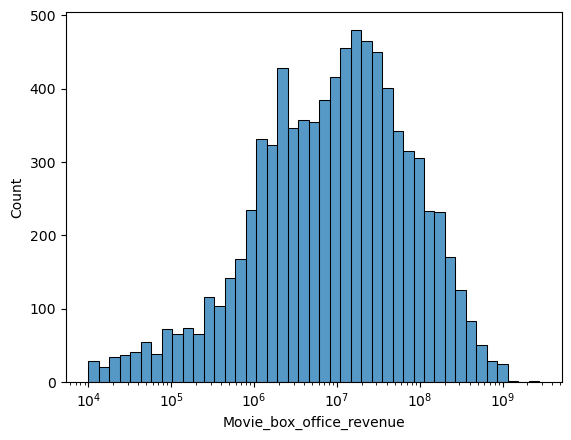

In [17]:
sns.histplot(data=movie,x='Movie_box_office_revenue',log_scale=True);

The spike around $ 1 million is weird, must be investigated.

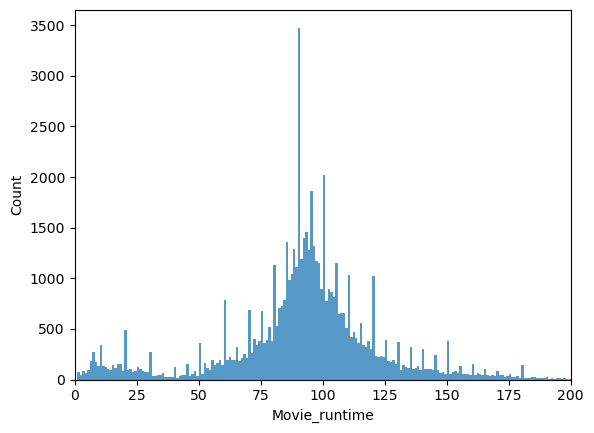

In [18]:
sns.histplot(data=movie,x='Movie_runtime',binwidth=1);
plt.xlim([0,200]);

- Lots of movie of 90 min

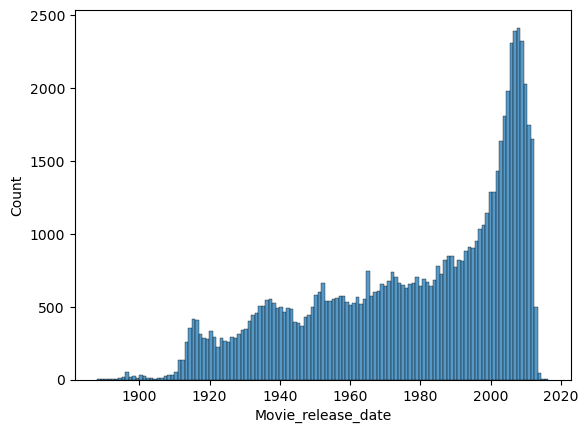

In [21]:
sns.histplot(data=movie,x='Movie_release_date', bins=(max(movie.Movie_release_date).year - min(movie.Movie_release_date).year + 1));

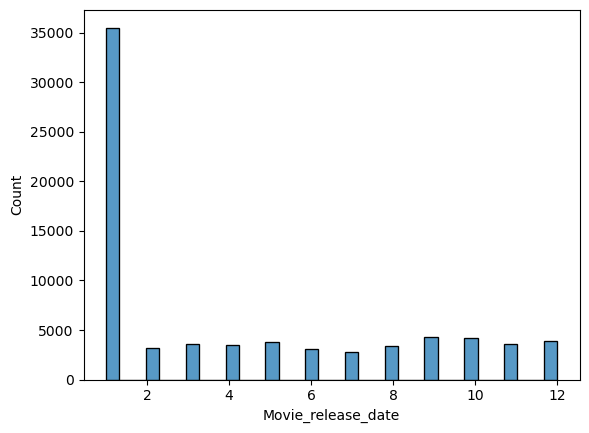

In [ ]:
sns.histplot(movie['Movie_release_date'].apply(lambda x: x.month));

- Because of `pd.to_datetime` which converts to the first day of the year a date with only the year indicated
- If monthly or daily analysis wanted, use `format = "%Y-%m-%d"`as argument of `pd.to_datetime`

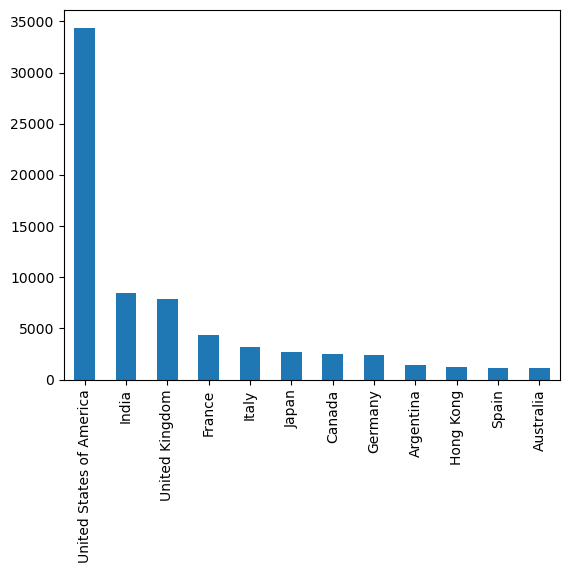

In [ ]:
movie_countries= movie['Movie_countries'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
movie_countries.loc[movie_countries.values>=1000].plot(kind='bar');

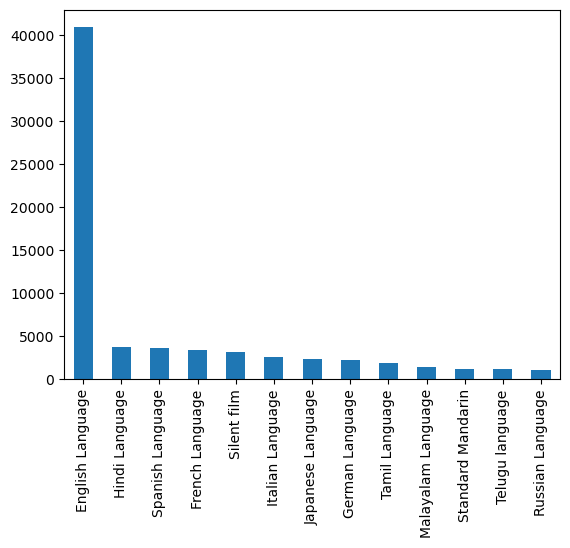

In [ ]:
movie_language = movie['Movie_languages'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
movie_language.loc[movie_language.values>=1000].plot(kind='bar');

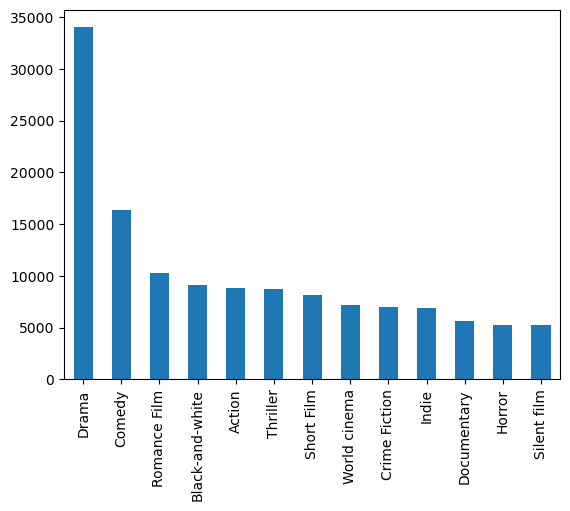

In [ ]:
movie_genres = movie['Movie_genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
movie_genres.loc[movie_genres.values>=5000].plot(kind='bar');

## Names of characters dataset

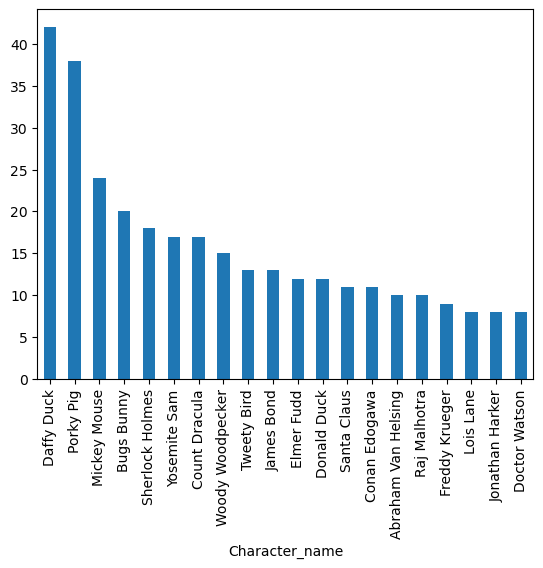

In [ ]:
name['Character_name'].value_counts().head(20).plot(kind='bar');

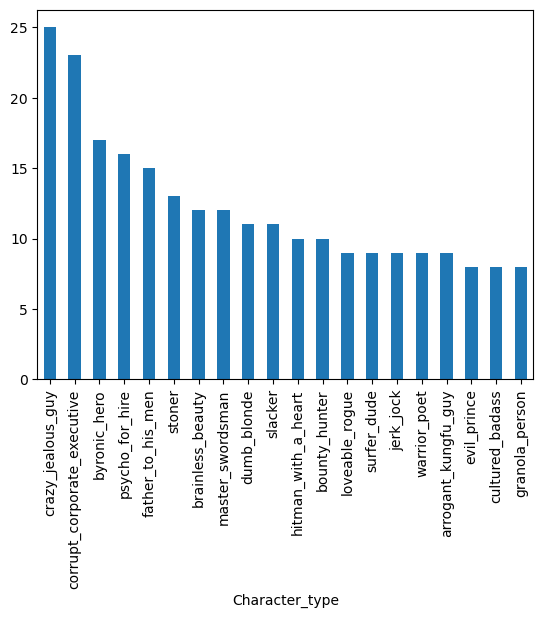

In [ ]:
character_type['Character_type'].value_counts().head(20).plot(kind='bar');

# Data processing pipeline and story telling

The purpose of the data gathering is to tell a story. 